## Step 0 - Visualization

In [8]:
import os
import librosa
import librosa.display

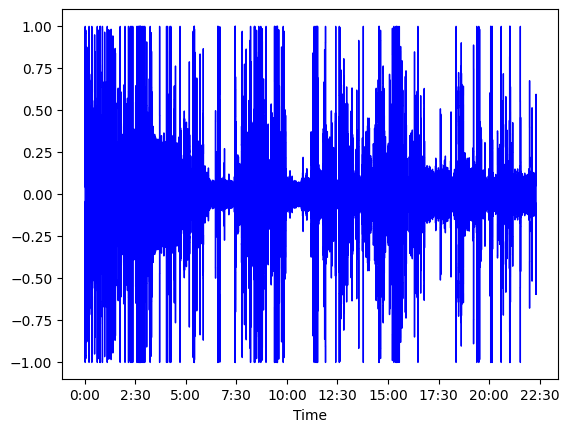

In [9]:
# Waveform by librosa
file ='audio.wav'
assert os.path.isfile(file)

wav, sr = librosa.load(file, sr=16000)
librosa.display.waveshow(wav,sr=sr, color='b')

## Step 1 - Noice cancellation

In [2]:
from scipy.io import wavfile
import noisereduce as nr

In [5]:
file ='audio.wav'
assert os.path.isfile(file)

rate, data = wavfile.read(file)

In [6]:
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("step1.wav", rate, reduced_noise)

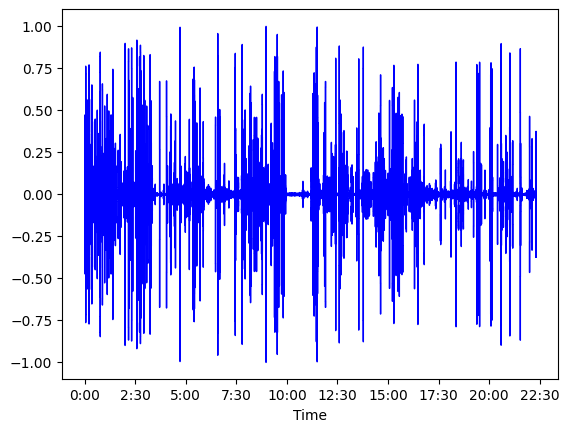

In [10]:
file ='step1.wav'
assert os.path.isfile(file)

wav, sr = librosa.load(file, sr=16000)
librosa.display.waveshow(wav,sr=sr, color='b')

## Step 2 - Slice slient parts

In [11]:
# To slice silent
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
# To save audios
from pydub import AudioSegment
# To create metadata
import json

### Detect silence

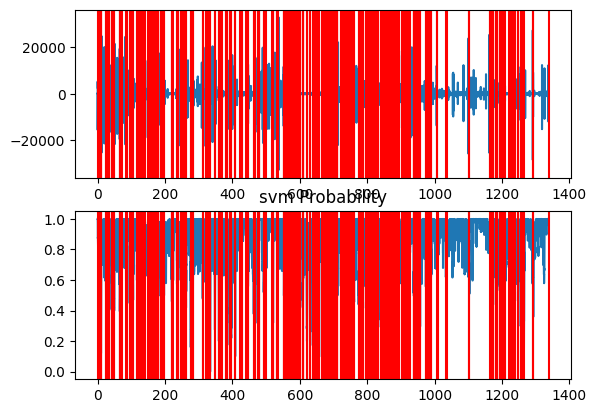

In [13]:
file = 'step1.wav'

assert os.path.isfile(file)

# below method returns the active / non silent segments of the audio file 
[Fs, x] = aIO.read_audio_file(file)
segments = aS.silence_removal(x, 
                             Fs, 
                             0.020, 
                             0.020, 
                             smooth_window=1.0, 
                             weight=0.3, 
                             plot=True)

### Remove too short windows

In [21]:
MIN_LENGTH, MIN_INTERVAL = 4, 3
START, END = 0, 1
modified_segments = [segment for segment in segments if segment[END] - segment[START] > MIN_LENGTH]
print(len(segments))
print(len(modified_segments))

combined_segments = [modified_segments[0][:]]
index = 1
while index < len(modified_segments):
    if modified_segments[index][START]-combined_segments[-1][END] > MIN_INTERVAL:
        combined_segments.append(modified_segments[index])
    else:
        combined_segments[-1][END] = modified_segments[index][END]
    index += 1

print(combined_segments, len(combined_segments))

199
91
[[0.0, 6.0200000000000005], [10.64, 31.46], [35.04, 65.66], [71.56, 94.74], [105.34, 127.48], [139.66, 154.66], [179.1, 186.52], [192.46, 255.58], [262.84000000000003, 321.94], [329.56, 380.92], [385.2, 391.8], [397.16, 423.62], [427.84000000000003, 440.78000000000003], [446.44, 552.7], [561.36, 566.04], [575.54, 595.94], [601.32, 637.82], [652.46, 667.02], [693.82, 704.34], [711.66, 737.02], [747.7, 795.88], [801.5, 808.36], [815.86, 821.24], [827.5600000000001, 855.94], [860.36, 870.6], [883.46, 908.9], [912.76, 981.04], [988.6, 1182.42], [1185.58, 1200.28], [1207.6200000000001, 1228.3600000000001], [1237.38, 1337.98]] 31


### Slice silent windows

In [22]:
myaudio = AudioSegment.from_wav(file)
if combined_segments:
    for index, segment in enumerate(combined_segments):
        extract = myaudio[segment[START]*1000:segment[END]*1000]
        extract.export(f'step2-{index}.wav', format="wav")

### Create audio metadata

In [23]:
metadata = [{ 'start_sec': segment[0], 'end_sec': segment[1] } for segment in combined_segments]
json_object = json.dumps(metadata, indent=4)
 
# Writing to sample.json
with open("audio_metadata.json", "w") as outfile:
    outfile.write(json_object)

## Check if speaking or randome sound

In [25]:
# Figure out some how. currently human work.
# randome sound -> 0, 1, 2, 4, 5, 6, 7, 12, 14, 15, 16, 17, 18, 21, 22, 28
# speaking -> (3), (8), (9), (10), (11), (13), (19), (20), (23), (24), (25), 26, 27, 